In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [54]:
adata = sc.read_h5ad('/Users/koush/Downloads/NormalLymphNodePuck_201014_06.h5ad')
adata

# adata = sc.read_h5ad('/Users/koush/Desktop/training_data/human_lymph_201014_06.h5ad')
# adata

AnnData object with n_obs × n_vars = 26027 × 23832
    obs: 'n_genes', 'n_UMIs', 'log10_n_UMIs', 'log10_n_genes', 'Cell_Type', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene', 'n_beads', 'n_UMIs', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'Cell_Type_colors', 'citation', 'schema_reference', 'schema_version', 'spatial', 'title'
    obsm: 'spatial'

In [55]:
adata = adata[:, adata.var.feature_type == 'protein_coding']
adata.var_names = adata.var.loc[adata.var_names].gene.values.copy()

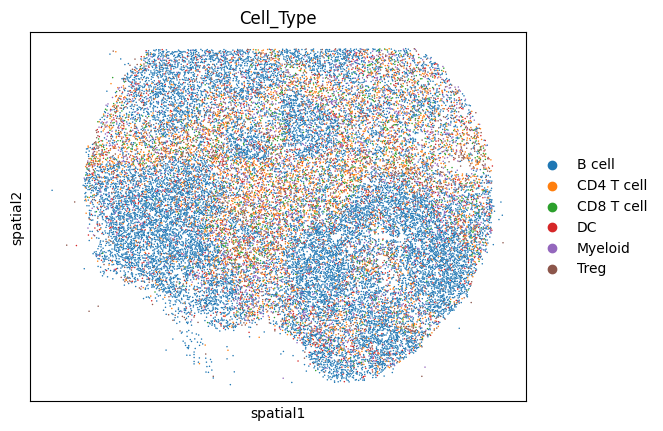

In [56]:
# %matplotlib inline
sc.pl.embedding(adata, basis='spatial', color=['Cell_Type'], ncols=2)

In [57]:
base_GRN = co.data.load_human_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [58]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)
ilr2_df =df_ligrec.query('receptor.str.contains("IL2") or ligand.str.contains("IL2")')
genes_of_interest = list(np.unique(ilr2_df.ligand.unique().tolist() + ilr2_df.receptor.unique().tolist()))
genes_of_interest = genes_of_interest + [
    'CCR7', 'CCL21', 'CXCR5','IL2', 'PAX5', 
    'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 
    'CXCL13', 'CXCL9', 'CCL19']

In [59]:
housekeeping_db = get_human_housekeeping_genes()

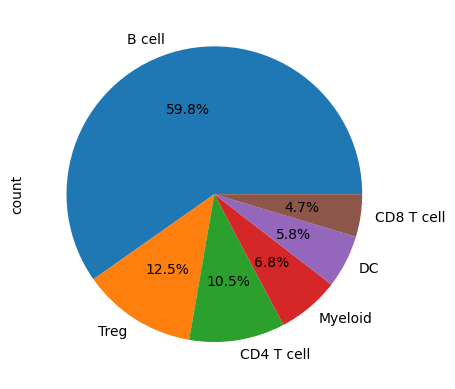

In [60]:
%matplotlib inline
adata.obs['Cell_Type'].value_counts().plot.pie(autopct='%.1f%%')
plt.show()

In [61]:
n_top_genes = 4000
min_cells = 10
min_counts = 100

In [62]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")
adata.var["RP"] = adata.var_names.str.startswith("RP")
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 20].copy()
adata = adata[:, ~adata.var["MT"]]
adata = adata[:, ~adata.var["RP"]]
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene.name'].unique())]

sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(genes_of_interest))]

adata.layers["normalized_count"] = adata.to_df().values.copy()
adata

AnnData object with n_obs × n_vars = 25273 × 4017
    obs: 'n_genes', 'n_UMIs', 'log10_n_UMIs', 'log10_n_genes', 'Cell_Type', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'
    var: 'gene', 'n_beads', 'n_UMIs', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type',

In [63]:
for key in ['n_genes', 'n_UMIs', 'log10_n_UMIs', 'log10_n_genes',
       'cell_type_ontology_term_id', 'organism_ontology_term_id',
       'tissue_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'is_primary_data', 'suspension_type', 'tissue_type',
       'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['gene', 'n_beads', 'n_UMIs', 'feature_is_filtered', 'feature_name',
       'feature_reference', 'feature_biotype', 'feature_length',
       'feature_type', 'MT', 'RP', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'n_cells', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [64]:
adata.obs['cell_type'] = adata.obs['Cell_Type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [65]:
adata

AnnData object with n_obs × n_vars = 25273 × 4017
    obs: 'Cell_Type', 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count'

In [66]:
pcs = BaseTravLR.perform_PCA(adata)
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 25273 cells and 4017 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 44.79 seconds.
    Calculating affinities...
    Calculated affinities in 44.97 seconds.
  Calculated graph and diffusion operator in 98.84 seconds.
  Calculating imputation...
  Calculated imputation in 3.19 seconds.
Calculated MAGIC in 102.08 seconds.


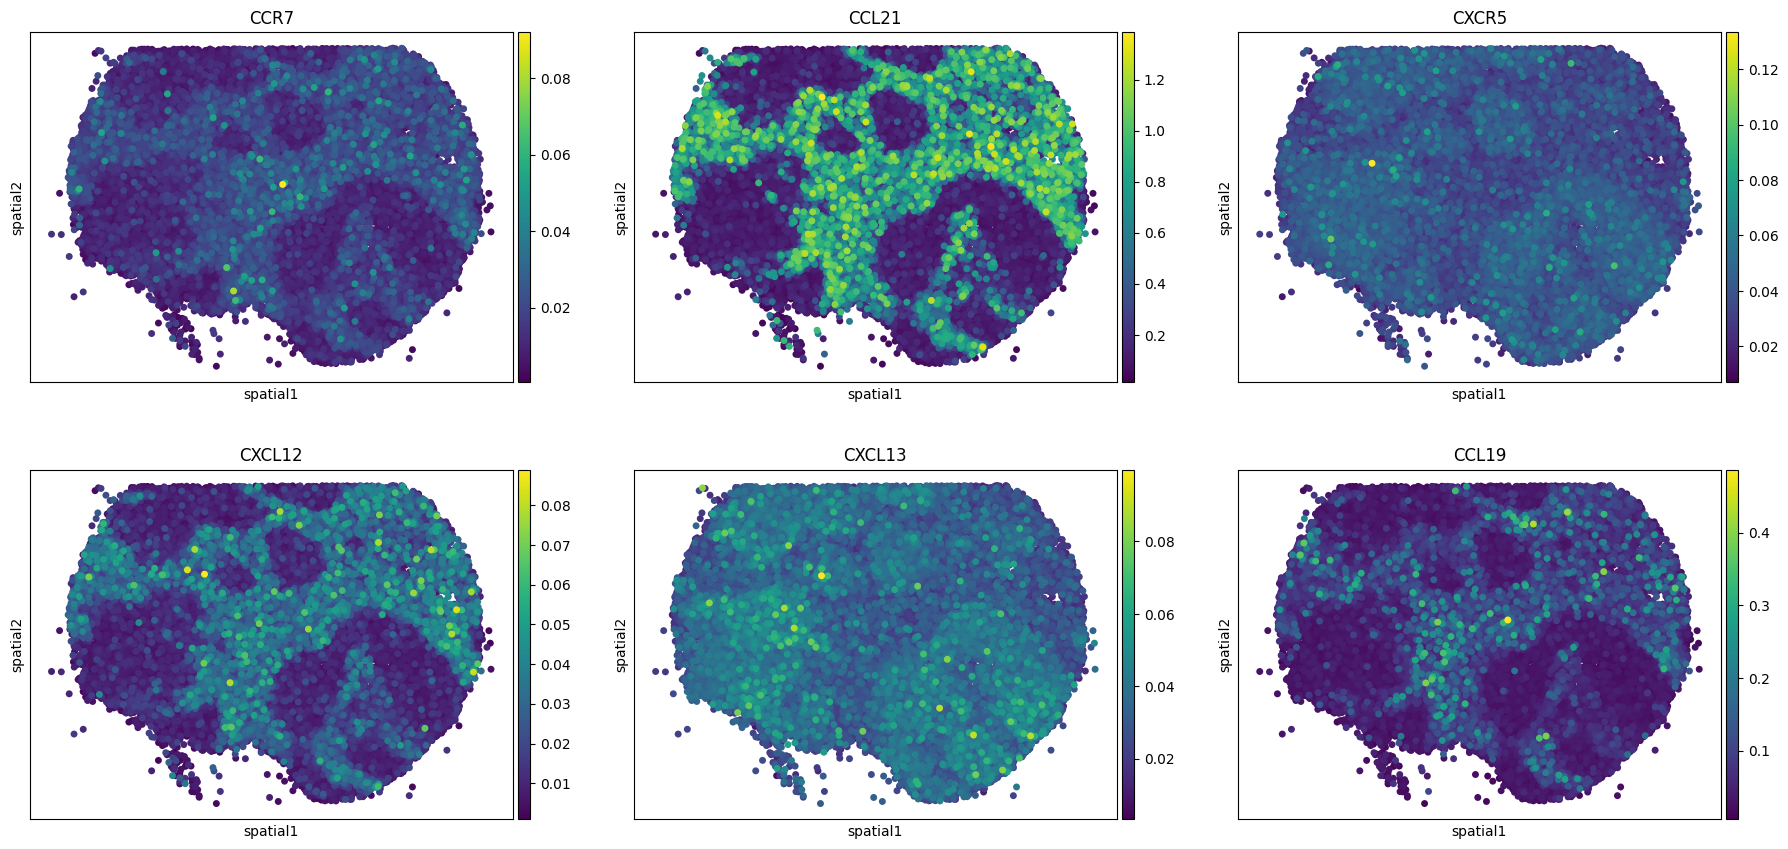

In [67]:
# %matplotlib inline
sc.pl.embedding(
    adata, basis='spatial', 
    color=['CCR7', 'CCL21', 'CXCR5', 'CXCL12', 'CXCL13', 'CCL19'], 
    s=100, ncols=3,
    layer='imputed_count'
)


In [20]:
# markers = np.intersect1d(
#     ['CD79A', 'RALGPS2', 'CD79B', 'MS4A1', 'BANK1', 
#     #  'CD74', 
#      'TNFRSF13C', 'HLA-DQA1', 'IGHM', 'MEF2C',
#     'IL7R', 'MAL', 'LTB', 'CD4', 'LDHB', 'TRAC', 'CD3D', 'CD3G', 
#     'CD8B', 'CD8A', 'CD3D', 'HCST', 'CD3G', 'LINC02446', 'CTSW', 'CD3E', 'TRAC',
#     'RTKN2', 'FOXP3', 'CD4', 'IL2RA', 'TIGIT', 'CTLA4', 'FCRL3', 'LAIR2', 'IKZF2'
# ], adata.var_names)

# sc.pl.dotplot(adata, markers, groupby='Cell_Type')

In [71]:
adata.write_h5ad('/Users/koush/Desktop/training_data/human_lymph_201014_06.h5ad')